# Set-up

In [9]:
import os
import sys
import scanpy as sc
import muon as mu

import seaborn as sns

sys.path.append("/cellar/users/aklie/opt/gene_program_evaluation/src/inference")
from factor_analysis import run_factor_analysis

In [3]:
path_data = "/cellar/users/aklie/opt/gene_program_evaluation/examples/datasets/Bridge_Samples/TSTDS36767099_IGVFB01_LeftCortex_Bridge_Parse.h5mu"
path_configs = "/cellar/users/aklie/opt/gene_program_evaluation/examples/inference/iPSC_EC/factor_analysis/config"
path_out = "/cellar/users/aklie/opt/gene_program_evaluation/examples/inference/iPSC_EC/factor_analysis"

# Load data

In [4]:
# if filepath ends in .h5ad
if path_data.endswith(".h5ad"):
    data = sc.read_h5ad(path_data)
elif path_data.endswith(".h5mu"):
    data = mu.read_h5mu(path_data)
data

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


MuData object with n_obs × n_vars = 98443 × 56953
  var:	'gene_id', 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
  1 modality
    rna:	98443 x 56953
      obs:	'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'bc', 'bc1_sequence', 'bc2_sequence', 'bc3_sequence', 'subpool', 'bc1_well', 'bc2_well', 'bc3_well', 'Mouse_Tissue_ID', 'plate', 'well_type', 'Tissue', 'Genotype', 'Protocol', 'Chemistry', 'Row', 'Column', 'SampleType', 'Sex', 'Age', 'Notes', 'DOB', 'Age_days', 'Body_weight_g', 'Estrus_cycle', 'Dissection_date', 'Dissection_time', 'Dissector', 'Tissue_weight_mg', 'Total_extracted_million', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'leiden', 'leiden_R', 'subpool_type', 'general_celltype', 'general_CL_ID', 'celltype', 'CL_ID', 'subtype', 'barcode', 'IGVF_accession', 'well', 'sample'
      var:	'gene_id', 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'Genotype_colors', 'celltype_colors', 'dendrogram_leiden_R', 'dendrogram_subtype', 'general_celltype_colors', 'hvg', 'leiden', 'leiden_R_colors', 'log1p', 'neighbors', 'subpool_colors', 'subpool_type_colors', 'subtype_colors', 'umap'
      obsm:	'X_pca', 'X_pca_harmony', 'X_umap', 'gene_expression_encoding'
      layers:	'PFlog1pPF_normalization', 'cellbender_counts', 'raw_counts'
      obsp:	'connectivities', 'distances'

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


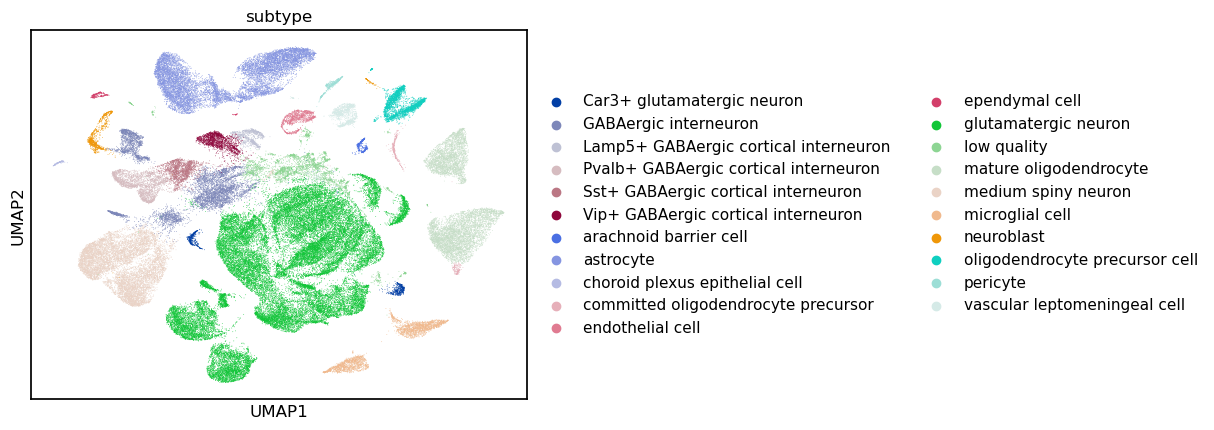

In [15]:
with sns.plotting_context("notebook", font_scale=1, rc={"figsize": (4, 4)}):
    sc.pl.umap(data.mod["rna"], color="subtype", show=False)

# (Optional) Preprocess

In [25]:
# Grab RNA
rna = data.mod["rna"].copy()
rna.X = rna.layers["raw_counts"].copy()
rna

: 

: 

: 

In [49]:
# Remove genes expressed in less than 50 cells
sc.pp.filter_genes(rna, min_cells=50)
rna

AnnData object with n_obs × n_vars = 214449 × 15897
    obs: 'barcodes', 'n_genes', 'n_counts', 'sample', 'batch'
    var: 'n_cells'
    layers: 'counts'

In [50]:
# Remove genes with names starting with ‘LINC’ and gene names with patterns starting with two letters and six digits
rna = rna[:, ~rna.var.index.str.startswith("LINC")].copy()
rna = rna[:, ~rna.var.index.str.match(r'^[A-Z]{2}\d{6}')].copy()
rna

AnnData object with n_obs × n_vars = 214449 × 15897
    obs: 'barcodes', 'n_genes', 'n_counts', 'sample', 'batch'
    var: 'n_cells'
    layers: 'counts'

In [51]:
# Normalize the data
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)

In [52]:
# Set layers
rna.layers["log1p_norm"] = rna.X.copy()
rna.X = rna.layers["counts"].copy()

In [53]:
# if mudata
if isinstance(rna, mu.MuData):
    # Put back into rna
    data.mod["rna"] = rna
else:
    # Make mudata
    data = mu.MuData({"rna": rna})

In [54]:
# Save 
data.write(path_data.replace(".h5mu", "_processed.h5mu"))

# (Optional) Make configs for running outside of the notebook
```yaml
run_factor_analysis_:
    n_components = 5
    random_state = 1234
```

In [44]:
# Configs look like above, make a separate one for 5, 10, 15, 20, 25, 30, 35, 40, 45, 50 100
'''
run_factor_analysis_:
    n_components = 5
    random_state = 1234
'''
def make_factor_analysis_config(path_out, path_configs, n_components):
    path_config = os.path.join(path_configs, f"factor_analysis_K{n_components}.gin")
    config = '''run_factor_analysis_:\n\tn_components = {n_components}\n\trandom_state = 1234'''
    config = config.format(n_components=n_components)
    with open(path_config, "w") as f:
        f.write(config)
    print(f"Saved config to {path_config}")
    return path_config

n_components = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100]
for n in n_components:
    make_factor_analysis_config(path_out, path_configs, n)

Saved config to /cellar/users/aklie/opt/gene_program_evaluation/dashapp/examples/bin/factor_analysis/config/factor_analysis_K5.gin
Saved config to /cellar/users/aklie/opt/gene_program_evaluation/dashapp/examples/bin/factor_analysis/config/factor_analysis_K10.gin
Saved config to /cellar/users/aklie/opt/gene_program_evaluation/dashapp/examples/bin/factor_analysis/config/factor_analysis_K15.gin
Saved config to /cellar/users/aklie/opt/gene_program_evaluation/dashapp/examples/bin/factor_analysis/config/factor_analysis_K20.gin
Saved config to /cellar/users/aklie/opt/gene_program_evaluation/dashapp/examples/bin/factor_analysis/config/factor_analysis_K25.gin
Saved config to /cellar/users/aklie/opt/gene_program_evaluation/dashapp/examples/bin/factor_analysis/config/factor_analysis_K30.gin
Saved config to /cellar/users/aklie/opt/gene_program_evaluation/dashapp/examples/bin/factor_analysis/config/factor_analysis_K35.gin
Saved config to /cellar/users/aklie/opt/gene_program_evaluation/dashapp/examp

# Run factor analysis

In [15]:
n_components = [100]
data_key = "rna"
layer = "norm10k"

In [16]:
# Run the factor analysis
for n in n_components:
    path_config = os.path.join(path_configs, f"factor_analysis_K{n}.gin")
    run_factor_analysis(
        mdata=data,
        prog_key=f"factor_analysis_K{n}",
        data_key=data_key,
        layer=layer,
        config_path=path_config,
        inplace=True
    )

INFO:root:Normalising and log transforming count data is reccomended before running FA.


In [20]:
# Save
data.write(os.path.join(path_out, "factor_analysis_K5.h5mu"))

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/mudata/_core/mudata.py:479: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(


# Quick eval

In [21]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [22]:
fa = mu.read_h5mu(os.path.join(path_out, "factor_analysis_K100.h5mu"))
fa

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/mudata/_core/mudata.py:479: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(


MuData object with n_obs × n_vars = 92284 × 5551
  2 modalities
    rna:	92284 x 5451
      obs:	'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'leiden', 'n_counts'
      obsm:	'X_pca', 'X_umap'
      layers:	'norm10k'
    factor_analysis_K100:	92284 x 100
      obs:	'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'leiden', 'n_counts'
      uns:	'loadings_genes'
      varm:	'loadings'

In [23]:
# Grab the factor loadings
adata = fa.mod["factor_analysis_K100"].copy()
adata.obsm["X_umap"] = fa.mod["rna"].obsm["X_umap"].copy()
adata

AnnData object with n_obs × n_vars = 92284 × 100
    obs: 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'leiden', 'n_counts'
    uns: 'loadings_genes'
    obsm: 'X_umap'
    varm: 'loadings'

/tmp/ipykernel_3440782/559434087.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Reds")


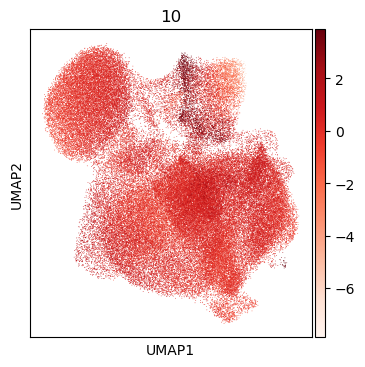

In [30]:
# Create a divergent colormap from grey to the current color using matplotlib
cmap = plt.cm.get_cmap("Reds")
with plt.rc_context({"figure.figsize": (4, 4)}):
    sc.pl.umap(adata, color=adata.var_names.tolist()[10], cmap=cmap, show=False, vmax="p99.5")

# DONE!

---